In [1]:
import os
import shutil
import importlib
import copy
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torchaudio

import phaselocknet_model
import util

importlib.reload(phaselocknet_model)
importlib.reload(util)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [2]:
regex_filenames = "/media/marmoset/data/code_package/phaselock/localization/speech_in_noise_in_reverb_stim.hdf5"
sr = 50000 if "localization" in regex_filenames else 20000
# num_steps_per_display = 10
dataset = util.HDF5Dataset(regex_filenames)

In [3]:
len(dataset)

18800

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # progress bar
# --- config ---
skip_like = {'signal'}     # avoid large arrays
outfile_csv = "stimuli_all_para.csv"         # output file name
# --------------

def to_scalar(x):
    # Convert numpy scalars / 0-d arrays to Python scalars
    if isinstance(x, (np.generic,)):
        return x.item()
    if isinstance(x, np.ndarray) and x.shape == ():
        return x.item()
    return x

# Determine which keys to keep (prefer dataset.keys attribute if present)
if hasattr(dataset, "keys") and isinstance(dataset.keys, (list, tuple)):
    candidate_keys = [k for k in dataset.keys if k not in skip_like]
else:
    probe = dataset[0]
    candidate_keys = [k for k in probe.keys() if k not in skip_like]

rows = []
# n = len(dataset)
for i in tqdm(range(len(dataset))):
# for i in range(n):
    sample = dataset[i]  # dict per sample
    row = {}
    for k in candidate_keys:
        v = sample[k]
        # coerce simple arrays/scalars to python scalars
        try:
            if isinstance(v, np.ndarray):
                if v.ndim == 0:
                    row[k] = v.item()
                elif v.size == 1:
                    row[k] = v.reshape(()).item()
                else:
                    # if accidental vector, store a short repr
                    row[k] = str(v.shape)
            else:
                row[k] = to_scalar(v)
        except Exception:
            row[k] = str(v)  # last resort

    rows.append(row)

df = pd.DataFrame(rows)

# Make sure SNR is numeric (keeps inf as np.inf; unparsable -> NaN)
if 'snr' in df.columns:
    df['snr'] = pd.to_numeric(df['snr'], errors='coerce')

# Optional: stable sort for readability
# for key in ['segment_id', 'index', 'foreground_index_brir']:
#     if key in df.columns:
#         df = df.sort_values(by=key, kind='mergesort')
#         break

# Save
# df.to_csv(outfile_csv, index=False)
# print(f"Saved {len(df):,} rows to {outfile_csv}")

# (Optional) also save Parquet (smaller, faster)
# df.to_parquet("room0_para.parquet", index=False)


100%|███████████████████████████████████| 18800/18800 [00:18<00:00, 1011.07it/s]


In [5]:
df["foreground_azim"].value_counts()

foreground_azim
80.0     2100
280.0    2100
0.0      2100
40.0     2100
340.0    2100
20.0     2100
60.0     2100
320.0    2050
300.0    2050
Name: count, dtype: int64

In [6]:
df["index_brir"].value_counts()

index_brir
16    2100
56    2100
0     2100
8     2100
68    2100
4     2100
12    2100
64    2050
60    2050
Name: count, dtype: int64

In [7]:
df["snr"].value_counts()

snr
-24.0    1880
-18.0    1880
-12.0    1880
-6.0     1880
 0.0     1880
 6.0     1880
 12.0    1880
 18.0    1880
 24.0    1880
 inf     1880
Name: count, dtype: int64

In [8]:
df["index_room"].value_counts()

index_room
0    3760
1    3760
2    3760
3    3760
4    3760
Name: count, dtype: int64

In [9]:
np.unique(df["label_word_int"])

array([  3,   5,   7,   8,  10,  11,  13,  14,  15,  17,  19,  20,  25,
        26,  27,  28,  29,  31,  33,  34,  36,  39,  40,  44,  45,  46,
        48,  53,  57,  58,  59,  63,  67,  69,  71,  73,  74,  76,  78,
        79,  80,  81,  82,  83,  84,  85,  95,  99, 101, 102, 104, 106,
       107, 108, 109, 110, 111, 112, 113, 116, 118, 121, 122, 123, 124,
       125, 128, 132, 135, 136, 137, 138, 139, 142, 143, 149, 150, 152,
       158, 159, 160, 162, 164, 168, 169, 171, 172, 174, 179, 180, 184,
       185, 187, 192, 193, 194, 195, 196, 198, 200, 202, 203, 208, 210,
       217, 220, 221, 226, 230, 234, 236, 237, 238, 240, 241, 245, 246,
       249, 254, 257, 258, 259, 267, 270, 271, 272, 273, 274, 277, 278,
       279, 281, 287, 288, 289, 291, 292, 293, 296, 297, 302, 304, 305,
       306, 309, 312, 313, 315, 316, 317, 318, 320, 321, 322, 323, 325,
       327, 328, 330, 331, 338, 343, 345, 348, 368, 369, 371, 373, 375,
       377, 382, 387, 391, 393, 395, 398, 399, 400, 401, 403, 40

In [10]:
np.unique(df["label_word_int"]).shape      ## full dataset is 794

(376,)

In [11]:
np.unique(df["label_speaker_int"]).shape   ## full dataset is 433

(164,)

In [12]:
df

,foreground_azim,foreground_dist,foreground_elev,index,index_brir,index_room,label_speaker_int,label_word_int,snr,sr
0,80.0,2.0,0.0,0,16,0,204,3,-24.0,44100
1,280.0,2.0,0.0,1,56,0,279,5,-24.0,44100
2,0.0,2.0,0.0,2,0,0,225,7,-24.0,44100
3,320.0,2.0,0.0,3,64,0,287,8,-24.0,44100
4,40.0,2.0,0.0,4,8,0,364,10,-24.0,44100
...,...,...,...,...,...,...,...,...,...,...
18795,0.0,2.0,0.0,371,0,4,276,785,inf,44100
18796,20.0,2.0,0.0,372,4,4,213,788,inf,44100
18797,280.0,2.0,0.0,373,56,4,431,789,inf,44100
18798,60.0,2.0,0.0,374,12,4,403,790,inf,44100


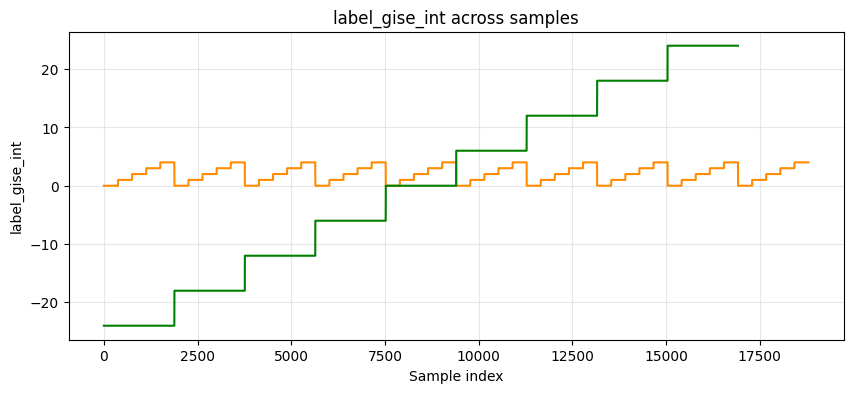

In [13]:
# df["index"].plot(figsize=(10, 4), color='pink')
df["index_room"].plot(figsize=(10, 4), color='darkorange')
df["snr"].plot(figsize=(10, 4), color='green')
plt.xlabel("Sample index")
plt.ylabel("label_gise_int")
plt.title("label_gise_int across samples")
plt.grid(alpha=0.3)
plt.show()

In [48]:
# example_id = 17125 ## 'label_word_int': 444, 'index_room': 0, 'snr': inf >>> -376, room==0 used in paper
# example_id = 17134 ## 'label_word_int': 460, 'index_room': 0, 'snr': inf

# example_id = 17501 ## 'label_word_int': 444, 'index_room': 1, 'snr': inf >>> anechoic
# example_id = 17505 ## 'label_word_int': 450,
# example_id = 17510 ## 'label_word_int': 460, 
# example_id = 17511 ## 'label_word_int': 461,

# example_id = 18629 ## 'label_word_int': 444, 'index_room': 4, 'snr': inf >>> +376*3, high reverb
# example_id = 18633 ## 'label_word_int': 450, 
example_id = 18638 ## 'label_word_int': 460, 
# example_id = 18639 ## 'label_word_int': 461,

dataset[example_id]['label_word_int']

460

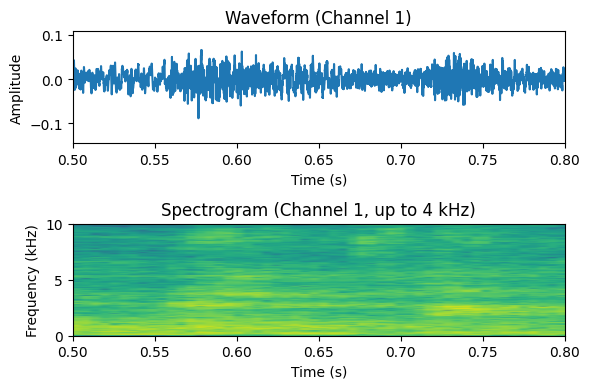

In [49]:
speech2C = dataset[example_id]['signal']

import torchaudio.transforms as T
from IPython.display import Audio

# Given:
# speech2C: numpy array of shape (57330, 2)
sr = 44100

# ---- 1. Extract first channel ----
wave_ch1 = speech2C[:,0].astype(np.float32)         # (T,)
t = np.arange(len(wave_ch1)) / sr

# ---- 2. Plot waveform (first channel) ----
plt.figure(figsize=(6, 4))

plt.subplot(2, 1, 1)
plt.plot(t, wave_ch1)
plt.xlim(0.5, 0.8)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform (Channel 1)")
# plt.tight_layout()
# plt.show()

# ---- 3. Compute spectrogram with torchaudio (first channel) ----
# torchaudio expects shape (channels, time)
wave_ch1_tensor = torch.from_numpy(wave_ch1).unsqueeze(0)   # (1, T)

N_FFT = 1024
WIN_LENGTH = 1024
HOP_LENGTH = 256
CENTER = True

spec_tf = T.Spectrogram(
    n_fft=N_FFT,
    win_length=WIN_LENGTH,
    hop_length=HOP_LENGTH,
    power=2.0,
    center=CENTER,
    window_fn=torch.hann_window
)

spec = spec_tf(wave_ch1_tensor)          # (1, freq_bins, time_frames)
spec_db = 10 * torch.log10(spec + 1e-10) # to dB for nicer visualization

# ---- 4. Plot spectrogram ----
max_freq = 10000  # Hz
# plt.figure(figsize=(6, 2))
plt.subplot(2, 1, 2)
plt.imshow(
    spec_db[0].numpy(),
    origin="lower",
    aspect="auto",
    extent=[0,
            spec_db.shape[-1] * HOP_LENGTH / sr,
            0,
            sr / 2]
)
plt.xlim(0.5, 0.8)
plt.ylim(0, max_freq)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (kHz)")
plt.yticks([0, 5000, 10000], ['0', '5', '10'])
plt.title("Spectrogram (Channel 1, up to 4 kHz)")
# plt.colorbar(label="Power (dB)")
plt.tight_layout()
plt.savefig('reverb_example_id'+str(example_id)+'_word_id'+str(dataset[example_id]['label_word_int'])
            +'_room_id'+str(dataset[example_id]['index_room'])+'.pdf', dpi=300, bbox_inches='tight')
plt.show()
# ---- 5. Play audio (first channel) ----
Audio(wave_ch1, rate=sr)
